In [1]:
import os
import pandas as pd
import yaml
import configparser

# Functions

In [2]:
# generate a list of legislators that have twitter handles
def parse_twitter_handles(config):
    yaml_doc_path = config.get('data', 'path') + '/' + config.get('data', 'twitter_yaml')
    if not os.path.isfile(yaml_doc_path):
        fetch_twitter_handles()
    yaml_doc = yaml.load(open(yaml_doc_path, 'r'))
    return [d for d in yaml_doc if 'twitter' in d['social']]

# create a dict where the key is the date and the value is a 
# list of lists [[moc, score],[moc, score],...] for that day
def parse_moc_scores(config, score_files):
    moc_scores = {}
    for f in score_files:
        score_path = config.get('data', 'path') + '/' + config.get('data', 'scores') + '/' + f
        if '.1.' in f:
            components = f.split('.')
            date = components[0]
            if components[2] == 'moc':
                with open(score_path) as score_file:
                    scores = score_file.readlines()
                moc_scores[date] = scores
    return moc_scores

# create a dict of scores for each legislator
# on each date for which scores are available
def read_scores(legislators, scores):
    leg_scores = {}
    for l in legislators:
        handle = l['social']['twitter'].lower()
        leg_scores[handle] = {}

    for date in scores:
        for score_item in scores[date]:
            handle, score = score_item.split()
            leg_scores[handle][date] = score
    return leg_scores

# main()

In [3]:
config = configparser.ConfigParser()
config.read('settings.cfg')
score_path = config.get('data', 'path') + '/' + config.get('data', 'scores') + '/'
score_files = os.listdir(score_path)
moc_scores = parse_moc_scores(config, score_files)
mocs_with_twitter = parse_twitter_handles(config)
moc_scores_by_date = read_scores(mocs_with_twitter, moc_scores)
df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in moc_scores_by_date.items()])).transpose().dropna(how='all')
data_file = config.get('data', 'path') + '/' + config.get('data', 'moc_scores')
df.to_csv(data_file, sep='\t')

Now read data file saved from AWS server and do next steps for analysis.

In [3]:
full_df = pd.read_csv('moc_scores_by_date.csv', sep = '\t')

Labor Day 2016 - Monday September 5. Tuesday, September 6 is 9 weeks before election. 2016-09-

In [4]:
all_dates = list(full_df.columns.values)
len(all_dates)

366

In [5]:
last_date = all_dates[365]
last_date

'2016-11-08'

In [6]:
import datetime
date_parts = last_date.strip('-')

start_date = datetime.date(2016, 9, 6)
end_date = datetime.date(2016, 11, 8)

In [7]:
date_parts

'2016-11-08'

In [8]:
len(last_date)

10

In [9]:
year = int(last_date[:4])
month = int(last_date[5:7])
day = int(last_date[8:])

In [10]:
interesting_dates = []
for date in all_dates:
    try:
        year = int(date[:4])
        month = int(date[5:7])
        day = int(date[8:])
    except:
        continue
    
    date_in_question = datetime.date(year, month, day)
    if start_date <= date_in_question <= end_date:
        interesting_dates.append(date)

In [11]:
interesting_df = full_df.filter(interesting_dates)
interesting_df.transpose()
#interesting_df.to_csv('purpletag_moc_scores_election_2016_transposed.csv', sep='\t')

,0,1,2,3,4,5,6,7,8,9,...,501,502,503,504,505,506,507,508,509,510
2016-09-06,NaN,NaN,-2.094980,NaN,NaN,NaN,-1.372290,NaN,NaN,-1.372290,...,-3.540360,-0.722689,NaN,NaN,NaN,NaN,2.767440,NaN,NaN,-1.372290
2016-09-07,NaN,NaN,-52.704000,NaN,NaN,NaN,-0.976000,NaN,NaN,-71.281500,...,-45.983600,-3.904000,21.482900,NaN,NaN,NaN,NaN,0.000295,NaN,-60.545500
2016-09-08,NaN,NaN,-76.581500,-2.871430,NaN,NaN,-1.914290,NaN,20.608200,-4.785720,...,-79.452900,NaN,22.985000,NaN,NaN,NaN,-0.914765,NaN,NaN,-79.452900
2016-09-09,NaN,NaN,-83.872500,NaN,NaN,NaN,NaN,1.934210,13.539500,-81.804500,...,-102.726000,NaN,8.703950,NaN,-4.53997,-79.736500,0.967105,NaN,1.934210,-108.365000
2016-09-10,NaN,NaN,-68.092100,NaN,NaN,NaN,-2.346460,1.422180,3.218790,-75.348400,...,-79.159300,NaN,19.693100,NaN,NaN,NaN,6.374280,0.852349,NaN,-74.086100
2016-09-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.884615,NaN,...,0.430518,-5.652150,NaN,NaN,NaN,NaN,0.884615,NaN,NaN,NaN
2016-09-12,NaN,NaN,NaN,NaN,1.379970,NaN,0.046126,NaN,1.379970,-2.013730,...,1.335830,1.379970,NaN,NaN,NaN,1.379970,1.379970,NaN,NaN,0.452943
2016-09-13,NaN,NaN,-103.656000,-2.303890,4.426230,NaN,NaN,NaN,2.696860,-3.388890,...,NaN,0.681980,8.008330,NaN,NaN,NaN,3.582100,NaN,NaN,-103.656000
2016-09-14,7.80347,NaN,-55.075900,-2.306660,NaN,NaN,-2.306670,NaN,NaN,-55.075900,...,-31.140000,1.151970,3.816060,NaN,-2.30667,-2.306660,2.019020,-0.010193,2.909600,-64.302600
2016-09-15,2.06060,NaN,-308.280000,NaN,14.770600,-1.941180,NaN,NaN,-5.163230,-231.233000,...,-75.706800,NaN,20.932500,-142.91700,NaN,NaN,NaN,1.030300,12.363600,-180.171000


# Legislator Info

In [ ]:
import yaml
yaml_doc = yaml.load(open('legislators-current.yaml', 'r'))
#return [d for d in yaml_doc if 'twitter' in d['social']]

In [ ]:
#yaml_doc[0]

In [ ]:
name = yaml_doc[0]['name']['official_full']
chamber = yaml_doc[0]['terms'][-1]['type']
state = yaml_doc[0]['terms'][-1]['state']

if yaml_doc[-1]['terms'][-1]['type'] == 'rep':
    district = yaml_doc[-1]['terms'][-1]['district']
else:
    district = 99

for x in reversed(range(len(yaml_doc[0]['terms']))):
    if yaml_doc[0]['terms'][x]['type'] == chamber:
        start = yaml_doc[0]['terms'][x]['start']
        
party = yaml_doc[0]['terms'][-1]['party']
url = yaml_doc[0]['terms'][-1]['url']

legislator = {'name': name, 'chamber': chamber, 'state': state, 'district': district, 'start_date': start, 'party': party, 'url': url}

In [ ]:
legislator

In [ ]:
all_reps = []
for item in yaml_doc:
    name = item['name']['official_full']
    chamber = item['terms'][-1]['type']
    state = item['terms'][-1]['state']
    # only house has district, senators are assigned district 99
    if item['terms'][-1]['type'] == 'rep':
        district = item['terms'][-1]['district']
    else:
        district = 99
    # start date of first term in current chamber
    for x in reversed(range(len(item['terms']))):
        if item['terms'][x]['type'] == chamber:
            start = item['terms'][x]['start']
    party = item['terms'][-1]['party']
    # not all reps have a url
    if 'url' in item['terms'][-1]:
        url = item['terms'][-1]['url']
    else:
        url = 'none'
    legislator = {'name': name, 'chamber': chamber, 'state': state, 'district': district, 'start_date': start, 'party': party, 'url': url}
    all_reps.append(legislator)

need to map this list of legislators to a list of twitter handles, not every rep uses twitter

In [ ]:
#TODO

# Time Series Analysis

In [13]:
%matplotlib inline
import os  
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
#import statsmodels.api as sm  
#import seaborn as sb  
#sb.set_style('darkgrid')

path = os.getcwd() + '/purpletag_moc_scores_election_2016_transposed.csv'  
election_data = pd.read_csv(path, sep = '\t')  
#stock_data['Date'] = stock_data[0].convert_objects(convert_dates='coerce')  
#stock_data = stock_data.sort_index(by='Date')  
#stock_data = stock_data.set_index('Date')  

In [15]:
election_data

del election_data['Unnamed: 0'] # remove extra column from cached file

In [17]:
#election_data

In [26]:
new_election_data = pd.DataFrame(election_data.transpose())
#dates = list(new_election_data.index)
#new_election_data['Date'] = dates
#new_election_data

In [27]:
dates = pd.date_range('2016-09-06', '2016-11-08', freq='D')

In [28]:
#dates

DatetimeIndex(['2016-09-06', '2016-09-07', '2016-09-08', '2016-09-09',
               '2016-09-10', '2016-09-11', '2016-09-12', '2016-09-13',
               '2016-09-14', '2016-09-15', '2016-09-16', '2016-09-17',
               '2016-09-18', '2016-09-19', '2016-09-20', '2016-09-21',
               '2016-09-22', '2016-09-23', '2016-09-24', '2016-09-25',
               '2016-09-26', '2016-09-27', '2016-09-28', '2016-09-29',
               '2016-09-30', '2016-10-01', '2016-10-02', '2016-10-03',
               '2016-10-04', '2016-10-05', '2016-10-06', '2016-10-07',
               '2016-10-08', '2016-10-09', '2016-10-10', '2016-10-11',
               '2016-10-12', '2016-10-13', '2016-10-14', '2016-10-15',
               '2016-10-16', '2016-10-17', '2016-10-18', '2016-10-19',
               '2016-10-20', '2016-10-21', '2016-10-22', '2016-10-23',
               '2016-10-24', '2016-10-25', '2016-10-26', '2016-10-27',
               '2016-10-28', '2016-10-29', '2016-10-30', '2016-10-31',
      

In [19]:
#new_election_data - removed from next line: convert_dates='coerce'
#new_election_data['Date'] #= new_election_data['Date'].convert_objects()  
#new_election_data = new_election_data.sort_index(by='Date')  
#new_election_data = new_election_data.set_index('Date')  

In [20]:
#new_election_data

In [21]:
#new_election_data[2].plot(figsize=(16, 12))  
#new_election_data.plot(figsize=(16, 12))  

In [22]:
#data = pd.read_csv('AirPassengers.csv')
print(new_election_data.head())
print('\n Data Types:')
print(new_election_data.dtypes)

            0    1         2        3    4    5        6        7         8    \
2016-09-06  NaN  NaN  -2.09498      NaN  NaN  NaN -1.37229      NaN       NaN   
2016-09-07  NaN  NaN -52.70400      NaN  NaN  NaN -0.97600      NaN       NaN   
2016-09-08  NaN  NaN -76.58150 -2.87143  NaN  NaN -1.91429      NaN  20.60820   
2016-09-09  NaN  NaN -83.87250      NaN  NaN  NaN      NaN  1.93421  13.53950   
2016-09-10  NaN  NaN -68.09210      NaN  NaN  NaN -2.34646  1.42218   3.21879   

                 9      ...            501       502       503  504      505  \
2016-09-06  -1.37229    ...       -3.54036 -0.722689       NaN  NaN      NaN   
2016-09-07 -71.28150    ...      -45.98360 -3.904000  21.48290  NaN      NaN   
2016-09-08  -4.78572    ...      -79.45290       NaN  22.98500  NaN      NaN   
2016-09-09 -81.80450    ...     -102.72600       NaN   8.70395  NaN -4.53997   
2016-09-10 -75.34840    ...      -79.15930       NaN  19.69310  NaN      NaN   

                506       507   

In [23]:
dates = new_election_data.index

In [24]:
dates

Index(['2016-09-06', '2016-09-07', '2016-09-08', '2016-09-09', '2016-09-10',
       '2016-09-11', '2016-09-12', '2016-09-13', '2016-09-14', '2016-09-15',
       '2016-09-16', '2016-09-17', '2016-09-18', '2016-09-19', '2016-09-20',
       '2016-09-21', '2016-09-22', '2016-09-23', '2016-09-24', '2016-09-25',
       '2016-09-26', '2016-09-27', '2016-09-28', '2016-09-29', '2016-09-30',
       '2016-10-01', '2016-10-02', '2016-10-03', '2016-10-04', '2016-10-05',
       '2016-10-06', '2016-10-07', '2016-10-08', '2016-10-09', '2016-10-10',
       '2016-10-11', '2016-10-12', '2016-10-13', '2016-10-14', '2016-10-15',
       '2016-10-16', '2016-10-17', '2016-10-18', '2016-10-19', '2016-10-20',
       '2016-10-21', '2016-10-22', '2016-10-23', '2016-10-24', '2016-10-25',
       '2016-10-26', '2016-10-27', '2016-10-28', '2016-10-29', '2016-10-30',
       '2016-10-31', '2016-11-01', '2016-11-02', '2016-11-03', '2016-11-04',
       '2016-11-05', '2016-11-06', '2016-11-07', '2016-11-08'],
      dtype=

In [ ]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
#data = new_election_data()
data = pd.read_csv('purpletag_moc_scores_election_2016_transposed.csv', parse_dates='Month', index_col='Month',date_parser=dateparse)
print(data.head())

There is a peak of - scores on September 11. 

In [ ]:
new_election_data['First Difference'] = new_election_data[2] - new_election_data[2].shift()  
new_election_data['First Difference'].plot(figsize=(16, 12)) 

In [ ]:
new_election_data['Natural Log'] = new_election_data[2].apply(lambda x: np.log(x))  
new_election_data['Natural Log'].plot(figsize=(16, 12)) 

# Another Try

Here's a dataframe where each row is a "time series" of one congressional rep scores over time.

In [50]:
interesting_df

,2016-09-06,2016-09-07,2016-09-08,2016-09-09,2016-09-10,2016-09-11,2016-09-12,2016-09-13,2016-09-14,2016-09-15,...,2016-10-30,2016-10-31,2016-11-01,2016-11-02,2016-11-03,2016-11-04,2016-11-05,2016-11-06,2016-11-07,2016-11-08
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.803470,2.060600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-2.094980,-52.704000,-76.581500,-83.872500,-68.092100,NaN,NaN,-103.656000,-55.075900,-308.280000,...,NaN,NaN,-90.838000,-61.343500,-40.482000,NaN,-33.451300,NaN,NaN,NaN
3,NaN,NaN,-2.871430,NaN,NaN,NaN,NaN,-2.303890,-2.306660,NaN,...,NaN,NaN,NaN,-17.954200,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,1.379970,4.426230,NaN,14.770600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.941180,...,NaN,NaN,NaN,-0.748092,NaN,NaN,NaN,NaN,NaN,NaN
6,-1.372290,-0.976000,-1.914290,NaN,-2.346460,NaN,0.046126,NaN,-2.306670,NaN,...,NaN,NaN,NaN,-6.732820,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,1.934210,1.422180,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,20.608200,13.539500,3.218790,0.884615,1.379970,2.696860,NaN,-5.163230,...,7.822220,3.75758,3.747290,34.176600,17.556800,11.632700,1.159570,0.607843,5,13.455900
9,-1.372290,-71.281500,-4.785720,-81.804500,-75.348400,NaN,-2.013730,-3.388890,-55.075900,-231.233000,...,NaN,NaN,-1.368150,-44.137400,-4.391300,-7.221050,-35.176100,NaN,NaN,-4.459010


In [17]:
from datetime import datetime
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as pyplot

In [24]:
dates = list(interesting_df)

In [25]:
dates

['2016-09-06',
 '2016-09-07',
 '2016-09-08',
 '2016-09-09',
 '2016-09-10',
 '2016-09-11',
 '2016-09-12',
 '2016-09-13',
 '2016-09-14',
 '2016-09-15',
 '2016-09-16',
 '2016-09-17',
 '2016-09-18',
 '2016-09-19',
 '2016-09-20',
 '2016-09-21',
 '2016-09-22',
 '2016-09-23',
 '2016-09-24',
 '2016-09-25',
 '2016-09-26',
 '2016-09-27',
 '2016-09-28',
 '2016-09-29',
 '2016-09-30',
 '2016-10-01',
 '2016-10-02',
 '2016-10-03',
 '2016-10-04',
 '2016-10-05',
 '2016-10-06',
 '2016-10-07',
 '2016-10-08',
 '2016-10-09',
 '2016-10-10',
 '2016-10-11',
 '2016-10-12',
 '2016-10-13',
 '2016-10-14',
 '2016-10-15',
 '2016-10-16',
 '2016-10-17',
 '2016-10-18',
 '2016-10-19',
 '2016-10-20',
 '2016-10-21',
 '2016-10-22',
 '2016-10-23',
 '2016-10-24',
 '2016-10-25',
 '2016-10-26',
 '2016-10-27',
 '2016-10-28',
 '2016-10-29',
 '2016-10-30',
 '2016-10-31',
 '2016-11-01',
 '2016-11-02',
 '2016-11-03',
 '2016-11-04',
 '2016-11-05',
 '2016-11-06',
 '2016-11-07',
 '2016-11-08']

In [27]:
row1 = interesting_df.iloc[0]

In [31]:
scores = row1.tolist()
scores

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 7.8034699999999999,
 2.0606,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 1.06429,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 3.6757,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 6.0426000000000002,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 1.5616099999999999,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [38]:
data = {'date': dates, 'score': scores}
df = pd.DataFrame(data, columns = ['date', 'score'])
print(df)

          date    score
0   2016-09-06      NaN
1   2016-09-07      NaN
2   2016-09-08      NaN
3   2016-09-09      NaN
4   2016-09-10      NaN
5   2016-09-11      NaN
6   2016-09-12      NaN
7   2016-09-13      NaN
8   2016-09-14  7.80347
9   2016-09-15  2.06060
10  2016-09-16      NaN
11  2016-09-17      NaN
12  2016-09-18      NaN
13  2016-09-19      NaN
14  2016-09-20      NaN
15  2016-09-21      NaN
16  2016-09-22      NaN
17  2016-09-23      NaN
18  2016-09-24      NaN
19  2016-09-25      NaN
20  2016-09-26      NaN
21  2016-09-27      NaN
22  2016-09-28  1.06429
23  2016-09-29      NaN
24  2016-09-30      NaN
25  2016-10-01      NaN
26  2016-10-02      NaN
27  2016-10-03      NaN
28  2016-10-04      NaN
29  2016-10-05      NaN
..         ...      ...
34  2016-10-10      NaN
35  2016-10-11      NaN
36  2016-10-12      NaN
37  2016-10-13      NaN
38  2016-10-14  6.04260
39  2016-10-15      NaN
40  2016-10-16      NaN
41  2016-10-17      NaN
42  2016-10-18      NaN
43  2016-10-19  

In [39]:
df['date'] = pd.to_datetime(df['date'])

In [40]:
df.index = df['date']
del df['date']
df

,score
date,
2016-09-06,NaN
2016-09-07,NaN
2016-09-08,NaN
2016-09-09,NaN
2016-09-10,NaN
2016-09-11,NaN
2016-09-12,NaN
2016-09-13,NaN
2016-09-14,7.80347


In [42]:
df['2016-11']

,score
date,
2016-11-01,NaN
2016-11-02,NaN
2016-11-03,NaN
2016-11-04,NaN
2016-11-05,NaN
2016-11-06,NaN
2016-11-07,NaN
2016-11-08,NaN


In [43]:
df.groupby(level=0).count()

,score
date,
2016-09-06,0
2016-09-07,0
2016-09-08,0
2016-09-09,0
2016-09-10,0
2016-09-11,0
2016-09-12,0
2016-09-13,0
2016-09-14,1


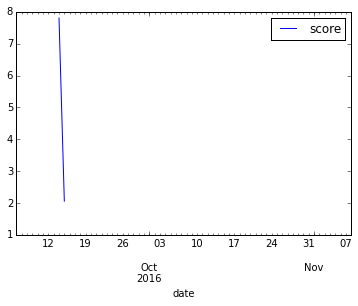

In [45]:
df.plot()

plot scores over time over dates before election.

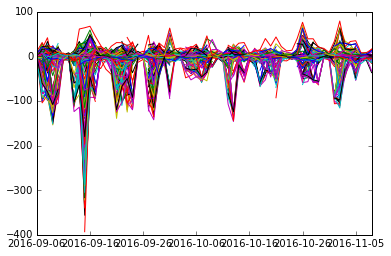

In [51]:
twisted = interesting_df.transpose()
twisted.plot(legend=False)